In [33]:
import lightgbm
import pandas as pd

In [34]:
data = pd.read_csv("../../Data/LWB_Monthly_data.csv")


In [35]:
init_record = data

In [36]:
init_record['_key_occurreddate_month']=init_record['_key_occurreddate_month'].astype("datetime64[ns]")
init_record = init_record.set_index(['_key_client_id', '_key_occurreddate_month'])

In [37]:
#init_record["Incident"] = init_record["response_variable"].values

In [38]:
print(init_record.shape)
init_record

(111736, 379)


incident_catgry_care_concern_piv  \
_key_client_id                       _key_occurreddate_month                                     
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                              0   
                                     2019-05-01                                              0   
                                     2019-06-01                                              0   
                                     2019-07-01                                              0   
                                     2019-08-01                                              0   
...                                                                                        ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                              0   
                                     2019-10-01                                              0   
                                     2019-11-01                                              0   
                                     2019-12-01                                              0   
                                     2020-01-01                                              0   

                                                              incident_catgry_medication_piv  \
_key_client_id                       _key_occurreddate_month                                   
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                            0   
                                     2019-05-01                                            0   
                                     2019-06-01                                            0   
                                     2019-07-01                                            0   
                                     2019-08-01                                            0   
...                                                                                      ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                            0   
                                     2019-10-01                                            0   
                                     2019-11-01                                            0   
                                     2019-12-01                                            0   
                                     2020-01-01                                            0   

                                                              incident_catgry_medical_piv  \
_key_client_id                       _key_occurreddate_month                                
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                         0   
                                     2019-05-01                                         0   
                                     2019-06-01                                         0   
                                     2019-07-01                                         0   
                                     2019-08-01                                         0   
...                                                                                   ...   
FFFF7C4D-F6DD-46D0-A9C0-AE3C2DC51132 2019-09-01                                         0   
                                     2019-10-01                                         0   
                                     2019-11-01                                         0   
                                     2019-12-01                                         0   
                                     2020-01-01                                         0   

                                                              incident_catgry__piv  \
_key_client_id                       _key_occurreddate_month                         
0000D172-EA88-432F-8235-9FAA00D29072 2019-04-01                                  0   
                                     2019-05-01                       

## Split Dataset to three part: Training, evaluation and testing data

In [39]:
import random
clientList = list(set(init_record.index.get_level_values(0)))

In [40]:
random.shuffle(clientList)

In [41]:
length = len(clientList)
ratio = int(length*0.2)
trainIDs = clientList[ratio:]
testIDs = clientList[:ratio]
train = init_record.drop(testIDs, level=0)
evl = init_record.drop(trainIDs, level=0)

In [42]:
print(train.shape)
print(evl.shape)

(89518, 379)
(22218, 379)


In [43]:
import numpy as np

In [44]:

def construct_feature_label(data):
    y = []
    clientList = list(set(data.index.get_level_values(0)))
    data['response_variable'] = data.groupby(level=0)['response_variable'].shift(-1)  
    data = data.groupby(level=0, as_index=False).apply(lambda group: group.iloc[:-1])
    #print(data.loc["0000D172-EA88-432F-8235-9FAA00D29072"]['response_variable'])
    y = data['response_variable'].astype('int32')
    x = data.drop('response_variable',axis='columns')
    return x, y

x_train, y_train = construct_feature_label(train)
x_eval, y_eval = construct_feature_label(evl)

In [45]:
print(len(y_train))
print(x_train.shape)
print(len(y_eval))
print(x_eval.shape)

79660
(79660, 378)
19754
(19754, 378)


# Normalize Data

In [46]:
#from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler()
#x_train = scaler.fit_transform(x_train)
#x_eval = scaler.transform(x_eval)

# Start training and predictions

In [47]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt


In [48]:
train_data = lightgbm.Dataset(x_train, label=y_train)
eval_data = lightgbm.Dataset(x_eval, label=y_eval)

In [49]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}


In [50]:
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=eval_data,
                       num_boost_round=2000)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's auc: 0.905143
[2]	valid_0's auc: 0.913172
[3]	valid_0's auc: 0.915557
[4]	valid_0's auc: 0.921692
[5]	valid_0's auc: 0.923082
[6]	valid_0's auc: 0.923817
[7]	valid_0's auc: 0.92541
[8]	valid_0's auc: 0.926194
[9]	valid_0's auc: 0.926823
[10]	valid_0's auc

[260]	valid_0's auc: 0.939586
[261]	valid_0's auc: 0.939616
[262]	valid_0's auc: 0.939597
[263]	valid_0's auc: 0.93962
[264]	valid_0's auc: 0.939732
[265]	valid_0's auc: 0.939714
[266]	valid_0's auc: 0.939748
[267]	valid_0's auc: 0.939809
[268]	valid_0's auc: 0.939815
[269]	valid_0's auc: 0.939805
[270]	valid_0's auc: 0.939815
[271]	valid_0's auc: 0.939795
[272]	valid_0's auc: 0.939789
[273]	valid_0's auc: 0.939844
[274]	valid_0's auc: 0.939877
[275]	valid_0's auc: 0.939844
[276]	valid_0's auc: 0.93987
[277]	valid_0's auc: 0.939836
[278]	valid_0's auc: 0.939802
[279]	valid_0's auc: 0.93981
[280]	valid_0's auc: 0.939854
[281]	valid_0's auc: 0.939934
[282]	valid_0's auc: 0.939928
[283]	valid_0's auc: 0.939947
[284]	valid_0's auc: 0.939949
[285]	valid_0's auc: 0.939902
[286]	valid_0's auc: 0.939918
[287]	valid_0's auc: 0.939913
[288]	valid_0's auc: 0.93989
[289]	valid_0's auc: 0.939841
[290]	valid_0's auc: 0.93983
[291]	valid_0's auc: 0.939848
[292]	valid_0's auc: 0.939817
[293]	valid_0's

[544]	valid_0's auc: 0.93934
[545]	valid_0's auc: 0.939363
[546]	valid_0's auc: 0.939419
[547]	valid_0's auc: 0.939436
[548]	valid_0's auc: 0.939463
[549]	valid_0's auc: 0.939493
[550]	valid_0's auc: 0.939458
[551]	valid_0's auc: 0.939499
[552]	valid_0's auc: 0.939501
[553]	valid_0's auc: 0.939546
[554]	valid_0's auc: 0.939564
[555]	valid_0's auc: 0.939563
[556]	valid_0's auc: 0.939592
[557]	valid_0's auc: 0.939555
[558]	valid_0's auc: 0.939564
[559]	valid_0's auc: 0.939532
[560]	valid_0's auc: 0.939521
[561]	valid_0's auc: 0.939512
[562]	valid_0's auc: 0.939485
[563]	valid_0's auc: 0.939455
[564]	valid_0's auc: 0.939389
[565]	valid_0's auc: 0.93933
[566]	valid_0's auc: 0.939328
[567]	valid_0's auc: 0.93931
[568]	valid_0's auc: 0.939277
[569]	valid_0's auc: 0.939284
[570]	valid_0's auc: 0.93929
[571]	valid_0's auc: 0.93926
[572]	valid_0's auc: 0.939139
[573]	valid_0's auc: 0.939099
[574]	valid_0's auc: 0.939054
[575]	valid_0's auc: 0.939032
[576]	valid_0's auc: 0.939109
[577]	valid_0's

[820]	valid_0's auc: 0.937007
[821]	valid_0's auc: 0.937021
[822]	valid_0's auc: 0.936955
[823]	valid_0's auc: 0.936995
[824]	valid_0's auc: 0.936957
[825]	valid_0's auc: 0.936986
[826]	valid_0's auc: 0.936953
[827]	valid_0's auc: 0.936964
[828]	valid_0's auc: 0.936963
[829]	valid_0's auc: 0.936954
[830]	valid_0's auc: 0.93695
[831]	valid_0's auc: 0.936958
[832]	valid_0's auc: 0.936939
[833]	valid_0's auc: 0.936925
[834]	valid_0's auc: 0.93693
[835]	valid_0's auc: 0.93691
[836]	valid_0's auc: 0.936912
[837]	valid_0's auc: 0.936936
[838]	valid_0's auc: 0.936933
[839]	valid_0's auc: 0.93689
[840]	valid_0's auc: 0.936885
[841]	valid_0's auc: 0.936828
[842]	valid_0's auc: 0.936782
[843]	valid_0's auc: 0.936721
[844]	valid_0's auc: 0.936718
[845]	valid_0's auc: 0.936728
[846]	valid_0's auc: 0.93671
[847]	valid_0's auc: 0.936703
[848]	valid_0's auc: 0.936711
[849]	valid_0's auc: 0.936729
[850]	valid_0's auc: 0.936748
[851]	valid_0's auc: 0.936741
[852]	valid_0's auc: 0.936742
[853]	valid_0's

[1098]	valid_0's auc: 0.935831
[1099]	valid_0's auc: 0.935845
[1100]	valid_0's auc: 0.935861
[1101]	valid_0's auc: 0.935864
[1102]	valid_0's auc: 0.935842
[1103]	valid_0's auc: 0.935875
[1104]	valid_0's auc: 0.935921
[1105]	valid_0's auc: 0.935936
[1106]	valid_0's auc: 0.935973
[1107]	valid_0's auc: 0.936024
[1108]	valid_0's auc: 0.936045
[1109]	valid_0's auc: 0.936052
[1110]	valid_0's auc: 0.936066
[1111]	valid_0's auc: 0.936112
[1112]	valid_0's auc: 0.936191
[1113]	valid_0's auc: 0.936192
[1114]	valid_0's auc: 0.936216
[1115]	valid_0's auc: 0.936243
[1116]	valid_0's auc: 0.936205
[1117]	valid_0's auc: 0.936197
[1118]	valid_0's auc: 0.936232
[1119]	valid_0's auc: 0.936231
[1120]	valid_0's auc: 0.93623
[1121]	valid_0's auc: 0.936236
[1122]	valid_0's auc: 0.936229
[1123]	valid_0's auc: 0.936212
[1124]	valid_0's auc: 0.936205
[1125]	valid_0's auc: 0.936182
[1126]	valid_0's auc: 0.936173
[1127]	valid_0's auc: 0.936146
[1128]	valid_0's auc: 0.936199
[1129]	valid_0's auc: 0.936174
[1130]	va

[1373]	valid_0's auc: 0.935046
[1374]	valid_0's auc: 0.93504
[1375]	valid_0's auc: 0.935031
[1376]	valid_0's auc: 0.935055
[1377]	valid_0's auc: 0.935049
[1378]	valid_0's auc: 0.935087
[1379]	valid_0's auc: 0.935094
[1380]	valid_0's auc: 0.935058
[1381]	valid_0's auc: 0.935049
[1382]	valid_0's auc: 0.935026
[1383]	valid_0's auc: 0.935045
[1384]	valid_0's auc: 0.935048
[1385]	valid_0's auc: 0.935054
[1386]	valid_0's auc: 0.935048
[1387]	valid_0's auc: 0.935046
[1388]	valid_0's auc: 0.935027
[1389]	valid_0's auc: 0.935007
[1390]	valid_0's auc: 0.934991
[1391]	valid_0's auc: 0.934984
[1392]	valid_0's auc: 0.935003
[1393]	valid_0's auc: 0.934996
[1394]	valid_0's auc: 0.934992
[1395]	valid_0's auc: 0.934967
[1396]	valid_0's auc: 0.93497
[1397]	valid_0's auc: 0.934936
[1398]	valid_0's auc: 0.934902
[1399]	valid_0's auc: 0.934902
[1400]	valid_0's auc: 0.934886
[1401]	valid_0's auc: 0.934885
[1402]	valid_0's auc: 0.934906
[1403]	valid_0's auc: 0.93487
[1404]	valid_0's auc: 0.934839
[1405]	vali

[1638]	valid_0's auc: 0.934099
[1639]	valid_0's auc: 0.934093
[1640]	valid_0's auc: 0.934062
[1641]	valid_0's auc: 0.9341
[1642]	valid_0's auc: 0.934078
[1643]	valid_0's auc: 0.934085
[1644]	valid_0's auc: 0.934124
[1645]	valid_0's auc: 0.934144
[1646]	valid_0's auc: 0.934173
[1647]	valid_0's auc: 0.934199
[1648]	valid_0's auc: 0.934233
[1649]	valid_0's auc: 0.934242
[1650]	valid_0's auc: 0.93427
[1651]	valid_0's auc: 0.934278
[1652]	valid_0's auc: 0.934277
[1653]	valid_0's auc: 0.934283
[1654]	valid_0's auc: 0.934307
[1655]	valid_0's auc: 0.934318
[1656]	valid_0's auc: 0.934329
[1657]	valid_0's auc: 0.934338
[1658]	valid_0's auc: 0.934398
[1659]	valid_0's auc: 0.934378
[1660]	valid_0's auc: 0.934345
[1661]	valid_0's auc: 0.934378
[1662]	valid_0's auc: 0.934342
[1663]	valid_0's auc: 0.93436
[1664]	valid_0's auc: 0.934335
[1665]	valid_0's auc: 0.934361
[1666]	valid_0's auc: 0.934346
[1667]	valid_0's auc: 0.934346
[1668]	valid_0's auc: 0.934331
[1669]	valid_0's auc: 0.934367
[1670]	valid

[1904]	valid_0's auc: 0.933495
[1905]	valid_0's auc: 0.933447
[1906]	valid_0's auc: 0.933396
[1907]	valid_0's auc: 0.9334
[1908]	valid_0's auc: 0.933352
[1909]	valid_0's auc: 0.933351
[1910]	valid_0's auc: 0.933373
[1911]	valid_0's auc: 0.933369
[1912]	valid_0's auc: 0.933334
[1913]	valid_0's auc: 0.933313
[1914]	valid_0's auc: 0.933276
[1915]	valid_0's auc: 0.933254
[1916]	valid_0's auc: 0.933274
[1917]	valid_0's auc: 0.93326
[1918]	valid_0's auc: 0.933263
[1919]	valid_0's auc: 0.933212
[1920]	valid_0's auc: 0.933213
[1921]	valid_0's auc: 0.933227
[1922]	valid_0's auc: 0.93321
[1923]	valid_0's auc: 0.933221
[1924]	valid_0's auc: 0.933211
[1925]	valid_0's auc: 0.933196
[1926]	valid_0's auc: 0.933199
[1927]	valid_0's auc: 0.933148
[1928]	valid_0's auc: 0.933166
[1929]	valid_0's auc: 0.93315
[1930]	valid_0's auc: 0.933153
[1931]	valid_0's auc: 0.93316
[1932]	valid_0's auc: 0.933154
[1933]	valid_0's auc: 0.933126
[1934]	valid_0's auc: 0.93313
[1935]	valid_0's auc: 0.933135
[1936]	valid_0'

## Evaluation

#### For evaluation data

In [51]:
y_scores = model.predict(x_eval)
y_hat = np.where(y_scores < 0.5, 0, 1)  
f1_score(y_eval,y_hat)

0.5158301158301158

In [52]:
from sklearn.metrics import classification_report

report = classification_report(y_eval, y_hat, labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     18269
           1       0.42      0.67      0.52      1485

    accuracy                           0.90     19754
   macro avg       0.69      0.80      0.73     19754
weighted avg       0.93      0.90      0.91     19754



#### For common test data

In [53]:
test = pd.read_csv("../../Data/LWB_Monthly_test.csv")


In [54]:
test['_key_occurreddate_month']=test['_key_occurreddate_month'].astype("datetime64[ns]")
test = test.set_index(['_key_client_id', '_key_occurreddate_month'])

In [55]:
x_test, y_test = construct_feature_label(test)

In [56]:
#model.predict(x_test)
test_scores = model.predict(x_test)
test_y_hat = np.where(test_scores < 0.5, 0, 1)  
f1_score(y_test,test_y_hat)

0.5306704707560628

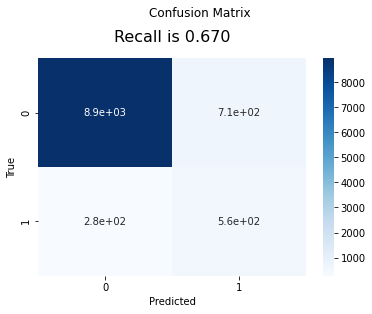

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,test_y_hat)
recal = cm[1][1]/sum(cm[1])

sns.heatmap(cm, annot=True,cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title(f'Recall is {recal:0.3f}',y=1.05, fontsize=16)
plt.suptitle('Confusion Matrix',y=1.06)

plt.savefig('Confusion_matrix.png')
plt.show()

In [57]:
report = classification_report(y_test,test_y_hat, labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      9659
           1       0.44      0.67      0.53       833

    accuracy                           0.91     10492
   macro avg       0.70      0.80      0.74     10492
weighted avg       0.93      0.91      0.91     10492



# Plotting the Loss

/Users/chenqinzhang/opt/anaconda3/envs/sem2_2020/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chenqinzhang/opt/anaconda3/envs/sem2_2020/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


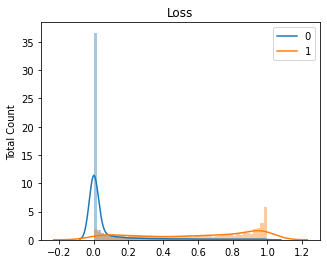

In [378]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 4))
for i in [0,1]:
    sns.distplot(y_scores[y_eval==i], bins=50,kde=True)
ax.set_ylabel('Total Count')
ax.set_title('Loss')
ax.legend('01')



In [379]:
confusion_matrix(y_eval,y_hat)

array([[21736,  1459],
       [  659,  1066]])

Text(0.5, 1.0, 'ROC curve')

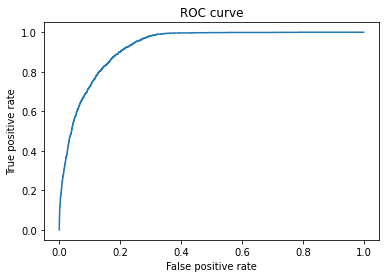

In [380]:
fpr, tpr, threshood = metrics.roc_curve(y_eval, y_scores, pos_label=1)
plt.plot(fpr, tpr, label='RT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

## Feature importance

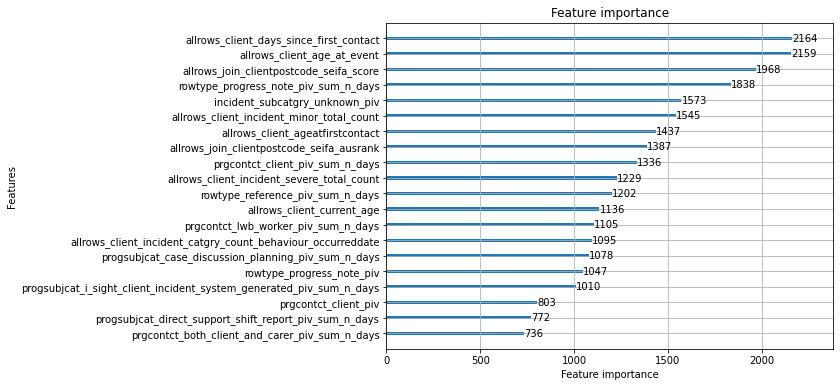

In [94]:
ax1 = lightgbm.plot_importance(model, figsize=(8,6),max_num_features=20)

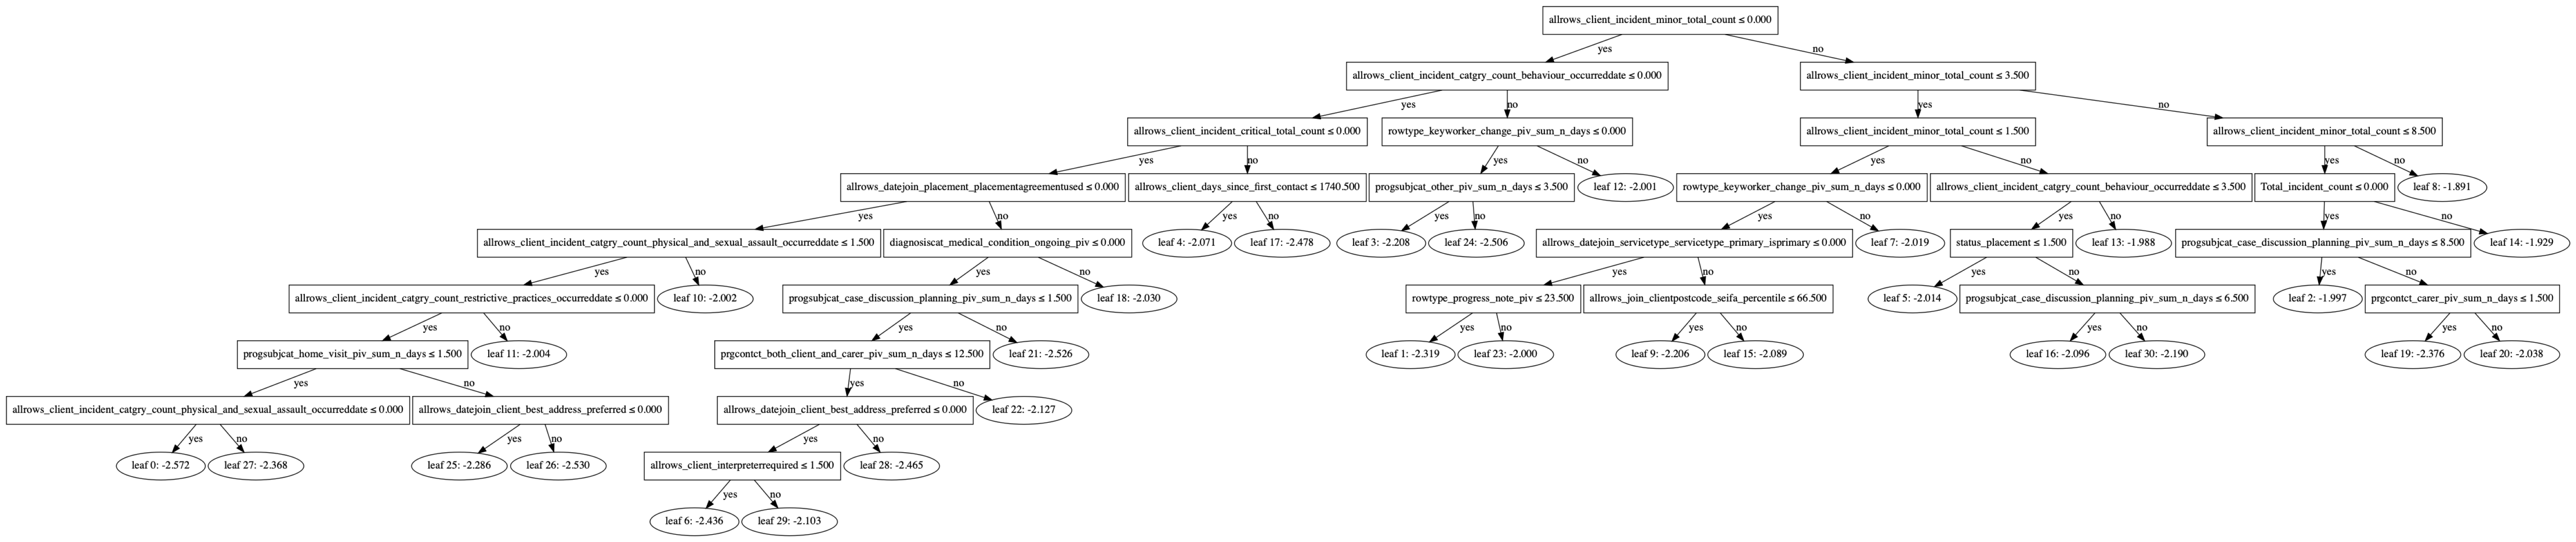

In [101]:
ax2 = lightgbm.plot_tree(model,figsize=(100,100),orientation='vertical')

In [96]:
ax3 = lightgbm.create_tree_digraph(model,orientation='vertical')

In [103]:
fig2 = ax2.get_figure()

In [104]:
fig2.savefig('decision_tree_small.png')

In [92]:
ax3.savefig('decision_tree_large.png')

AttributeError: 'Digraph' object has no attribute 'savefig'

In [385]:
positive = sum(list(y_train))
print(positive)
negative = len(y_train) - positive
print(negative)



5605
68181


In [386]:
import math
def probability(leaf):
    p = math.exp(leaf)/(1+math.exp(leaf))
    return p

probability(-1.872)

0.1333104754333704

# Cross validation

In [26]:
model_cv = lightgbm.cv(parameters,
                       train_data,
                       num_boost_round=2000,return_cvbooster=True)

[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Current value: objective=binary
[LightGBM] [Warning] objective is set=binary, application=binary will be ignored. Curre

In [27]:
cv_result = model_cv["cvbooster"].predict(x_eval)

In [28]:
cv_result = np.array(cv_result)

#### Mean vote

In [29]:
y_hat = np.where(cv_result.mean(axis=0) < 0.5, 0, 1) 
f1_score(y_eval,y_hat)

0.5347732181425486